In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import scipy
from scipy import signal

In [4]:
#Segment the activity into avalanche duration.
def findQuiesence(raster):
    first = True
    no_act = []
    for i in range(raster.shape[1]):#along column space (i.e. per time step)
        tstep = raster[:,i]
        if sum(tstep) == 0 and first:
            curr_quiet = [i]
            first = False
        elif sum(tstep) != 0 and not first:
            if (i - 1) != curr_quiet[0]:#if the quiet period is longer than one time step
                curr_quiet.append(i-1)#append end step of quiesence
            no_act.append(curr_quiet)#add the current quiet period to the list of all quiet periods
            first = True#tell the loop that the next quiet time step is the start of a quiescence period
        
        if (not first) and (i == raster.shape[1]) and ((i - 1) != curr_quiet[0]):
            curr_quiet.append(i)#append end step of quiesence
            no_act.append(curr_quiet)#add the current quiet period to the list of all quiet periods
    
    avas = []
    if len(no_act) > 1:
        for itr in range(len(no_act) - 1):
            #if the first instance of quiesence is not the first entry, then
            #add an avalanche period starting form t0 and running to the first
            #instance of quiesence
            if itr == 0 and no_act[itr][0] != 0:
                avas.append([0, no_act[itr][0]-1])
            else:
                curr = no_act[itr]
                next = no_act[itr+1]
                if len(curr)>1:
                    end_q = curr[-1]
                else:
                    end_q = curr[0]
                start_q = next[0]

                avas.append([end_q+1, start_q-1])

        if no_act[itr + 1][-1] < raster.shape[1]:
            avas.append([no_act[itr + 1][-1]+1, raster.shape[1]])

    elif len(no_act) == 1:
        if no_act[0][0] != 0:#if the start of no activity is not the first entry
            avas.append([0, no_act[0][0]])
        avas.append([no_act[0][-1]+1, raster.shape[1]])
        

    return no_act, avas

#Pytorch Model Classes
# NOTE: using multiplicative Gaussian noise here
def heaviside(x, values=None):
    if values != None:
        assert (len(values) == len(x))
    else:
        values = torch.zeros_like(torch.flatten(x))
    
    x_shape = tuple(list(x.size()))
    out = torch.zeros_like(torch.flatten(x))
    for i, entry in enumerate(torch.flatten(x)):
        if entry == 0.:
            out[i] = values[i]
        elif entry > 0.:
            out[i] = 1.


    return torch.reshape(out, x_shape)


def makeBanded(dim, c):
    A = torch.ones((dim,dim))
    B = torch.ones((dim, dim))
    A = torch.triu(A, diagonal=-c)
    B = torch.tril(B, diagonal=c)
    mask = A*B
    return mask

def makeRandomMask(dim, c):
    A = np.zeros((dim, dim))
    inds = np.arange(dim)
    for i in range(A.shape[0]):
        conn_inds = np.random.choice(inds, size=c, replace=False, p=None)
        A[i, conn_inds] = 1.0
    return torch.from_numpy(A).type(torch.FloatTensor)

def initDirichlet(dim, c, alpha, scale, diag=False):
    alphas = np.random.uniform(0.0,alpha,c)
    D = np.random.dirichlet(alphas,size=dim)*scale
    A = np.zeros((dim, dim))
    inds = np.arange(dim)
    for i in range(A.shape[0]):
        if diag:
            conn_inds = np.random.choice(inds, size=c, replace=False, p=None)
        else:
            conn_inds = np.random.choice(np.delete(inds, i), size=c, replace=False, p=None)

        A[i, conn_inds] = D [i, :]
    
    return torch.from_numpy(A).type(torch.FloatTensor)


def initNormColumn(dim, c, scale, diag=False):
    #need to ensure that a single column of the weight matrix does not end up with only
    #zeros as entries, this will cause the normalization to return NaNs. Accomplish this
    #with the while condition s.t. the loop repeats and creats another weight matrix
    #if ANY column of weights sums to zero.
    A = np.zeros((dim, dim))
    while len(np.where(np.sum(A, axis=0) == 0)[0]) > 0:
        A = np.zeros((dim, dim))
        inds = np.arange(dim)

        for i in range(A.shape[0]):
            if diag:
                conn_inds = np.random.choice(inds, size=c, replace=False, p=None)
            else:
                conn_inds = np.random.choice(np.delete(inds, i), size=c, replace=False, p=None)

            A[i, conn_inds] = np.random.uniform(0.,1.,c)

    A = scale*A/np.sum(A, axis=0)#divide each column by its sum to constrain the weights to sum to 1.
    assert np.isclose(dim*scale, np.sum(np.sum(A, axis=0)))#asserts that the sum down zero axis for each column is 1.
    return torch.from_numpy(A).type(torch.FloatTensor)

class CoupledGaussianDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(CoupledGaussianDropout, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        """
        Sample noise   e ~ N(0, alpha)
        Add noise h = h_ * (1 + e)
        """
        epsilon = torch.randn_like(x) * self.alpha + 1

        return x * epsilon
        
def Symmetric(X):
    ''' 
    Make matrix symmetric by copying the upper-triangular part of the matrix into its lower-triangular part
    '''
    return X.triu() + X.triu(1).transpose(-1, -2)

def Skew(X):
    ''' 
    Make matrix skew symmetric by copying the upper-triangular part of the matrix into its lower-triangular part
    '''
    A = X.triu(1)
    return A - A.transpose(-1, -2)

# Adapted from: https://mlexplained.com/2019/02/15/building-an-lstm-from-scratch-in-pytorch-lstms-in-depth-part-1/
class OptimizedRNN(nn.Module):

    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 noise_std=0.0, 
                 nonlin_hid = None,
                 nonlin_out = None,
                 device = 'cpu',
                 w_init = None,
                 w_noise_gain = 1.0,
                 threshold=None,
                 c=3,
                 a=100):

        super(OptimizedRNN, self).__init__()
        self.n_layers = 1
        self.device = device
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nonlin_hid = nonlin_hid
        self.nonlin_out = nonlin_out
        self.w_noise_gain = w_noise_gain
        self.alpha = a
        self.noise_std = noise_std

        #check for heaviside nonlinearity and threshold kwarg
        if nonlin_hid == 'heaviside':
            self.threshold = threshold
        if (w_init == 'banded') or (w_init == 'random') or (w_init == 'Dirichlet') or (w_init == 'Col_Norm'):
                self.c = c
                if w_init == 'Dirichlet':
                    self.a = a
        

        self.noise = CoupledGaussianDropout(
            alpha=noise_std) if noise_std > 0 else None

        self.register_parameter(
            'weight_ih', nn.Parameter(torch.Tensor(input_dim, hidden_dim)))
        self.register_parameter(
            'weight_hh', nn.Parameter(torch.Tensor(hidden_dim, hidden_dim)))
        self.register_parameter(
            'bias', nn.Parameter(torch.Tensor(hidden_dim)))
        

        self.linear = nn.Linear(hidden_dim, output_dim)
        self.init_weights(w_init)
        
    def init_weights(self, w_init):
        if w_init == 'Vartak':
            N = self.hidden_dim
            for name, param in self.named_parameters():
                if 'weight_ih' in name:
                    #input weights
                    #Gaussian distribution with zero mean and variance 1/N. Motivated by findings from 
                    #(Sussillo & Abbott, 2015),  also scale Whx by a factor of a,
                    a = math.sqrt(2)*math.exp(1.2/(max(N, 6) - 2.4))
                    std = math.sqrt(1/N)
                    nn.init.normal_(param.data, mean = 0.0, std = std)
                    param.data = param.data*a
                    
                elif 'weight_hh' in name:
                    #recurrent
                    R = torch.normal(mean = 0.0, std=1.0, size = (N, N))
                    R_T = torch.transpose(R, 0, 1)
                    A = (1/N)*torch.matmul(R, R_T)
                    eigs, evs = torch.eig(A, eigenvectors=False)
                    eig_max = torch.max(eigs)
                    Whh = A / eig_max
                    param.data = Whh
                    
                elif 'bias' in name:
                    pass
            
            for name, param in self.linear.named_parameters():
                if 'weight' in name:
                    #output weights
                    fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(param.data)
                    out_std = np.sqrt(2 / (fan_in + fan_out))
                    nn.init.normal_(param.data, mean = 0.0, std = out_std)
        
        elif w_init == 'Dirichlet':
            for name, param in self.named_parameters():
                if ('weight_hh' in name):
                    param.data = initDirichlet(self.hidden_dim, c=self.c, alpha=self.alpha, scale=self.w_noise_gain)

        elif w_init == 'Col_Norm':
            for name, param in self.named_parameters():
                if ('weight_hh' in name):
                    param.data = initNormColumn(self.hidden_dim, c=self.c, scale=self.w_noise_gain, diag=False)
        
        else:
            stdv = self.w_noise_gain*(1/ math.sqrt(self.hidden_dim))
            for name, param in self.named_parameters():
                nn.init.uniform_(param, -stdv, stdv)
                if ('weight_hh' in name) and (w_init=='symmetric'):
                    A = Symmetric(param.data)
                    assert torch.allclose(A, A.T)
                    param.data = A
                if ('weight_hh' in name) and (w_init=='skew'):
                    A = Skew(param.data)
                    param.data = A
                if ('weight_hh' in name) and (w_init == 'banded'):
                    mask = makeBanded(self.hidden_dim, self.c)
                    param.data = mask*param.data
                if ('weight_hh' in name) and (w_init == 'random'):
                    mask = makeRandomMask(self.hidden_dim, self.c)
                    param.data = mask*param.data



    def init_hidden(self, gain, batch_size=128):
        """Initialize hidden state of RNN."""
        A = torch.zeros((self.n_layers, batch_size, self.hidden_dim))
        rand_on = torch.randint(0, hidden_dim, (1,))
        A [:, :, rand_on] = 1
        return A.type(torch.FloatTensor).to(self.device)
        # return torch.reshape(torch.multinomial(torch.tensor([0.5, 0.5]), num_samples=self.n_layers*batch_size*self.hidden_dim, replacement=True), (self.n_layers, batch_size, self.hidden_dim)).type(torch.FloatTensor).to(self.device)
        # return gain*torch.randn(self.n_layers, batch_size, self.hidden_dim).to(self.device)
        # return gain*torch.ones(self.n_layers, batch_size, self.hidden_dim).to(self.device)

    def forward(self, inputs):
        """Assumes input is of shape (batch, sequence, feature)"""

        hidden = []
        for i in range(inputs.shape[1]):
            x = inputs[:, i, :]
            # batch the computations into a single matrix multiplication
            self.hidden = x @ self.weight_ih + self.hidden @ self.weight_hh# + self.bias
            if self.nonlin_hid == 'relu':
                if self.noise:
                    self.hidden = F.relu(self.noise(self.hidden))
                else:
                    self.hidden = F.relu(self.hidden)
            elif self.nonlin_hid == 'tanh':
                if self.noise:
                    self.hidden = torch.tanh(self.noise(self.hidden))
                else: 
                    self.hidden = torch.tanh(self.hidden)
            elif self.nonlin_hid == 'heaviside':
                if self.noise:
                    epsilon = torch.rand(self.hidden.size()).to(self.device)
                    # epsilon = torch.randn(self.hidden.size()).to(self.device)
                    self.hidden = heaviside(self.hidden + epsilon - self.threshold)
                else: 
                    self.hidden = heaviside(self.hidden - self.threshold)
            else:#linear RNN
                if self.noise:
                    self.hidden = self.noise(self.hidden)
                else:
                    self.hidden = self.hidden

            hidden.append(self.hidden)

        hidden = torch.cat(hidden, dim=0)
        hidden = hidden.transpose(0, 1).contiguous()

        if self.nonlin_out == 'relu':
            output = F.relu(self.linear(hidden))
        elif self.nonlin_out == 'tanh':
            output = torch.tanh(self.linear(hidden))
        else:
            output = self.linear(hidden)

        return output, hidden, inputs

In [5]:
def test_model(test_dataloader, batch_size, loss_function, model, model_type, **kwargs):
    """Tests network model of specified type.
    
    :param batched_test_data: numpy array of the test data shaped as (batch = batch_size, seq_len = input_length,  input_size = dim)
    :param batched_test_output_data: numpy array of the test output data shaped as (batch = batch_size, seq_len = input_length,  input_size = dim)
    :param batch_size: the number of input data sequences contained in each batch
    :param model: pytorch model object
    :param model_type: model object 'type' can be: STSP, RNN, LSTM, RNN_STSP, RNN_STSP_tau, RNSTSP, or RNSTSP_tau

    :return return_dict: test model data. The dictionary keys include: predictions: model predicted values, and accuracy: distance between actual and predicted values,
    in this case it is a input variance normalized L2-norm distance. The returned
    dictionary will also have a key tau_vals if the trained model has the synaptic dynamics time constant, tau, as a trained parameter. The tau_vals
    key will then refer to a list of the time constant values for each training batch.
    """
        
    if model_type == 'RNN':
        hidden = model.init_hidden(batch_size)#initialize hidden state
        #print('hidden_init:' + str(hidden))
    elif model_type == 'OptimizedRNN':
        if 'gain' in kwargs.keys():
            gain = kwargs['gain']
        else:
            gain = 1.0
        model.hidden = model.init_hidden(gain, batch_size)#initialize hidden state
        
    elif model_type == 'RNSTSP':
        hidden = model.init_hidden(batch_size)
        syn_x = model.init_synaptic_resources()
        syn_x = syn_x.repeat(batch_size, 1)
        #print('hidden_init:' + str(hidden))
        #print('syn_x_init:' + str(syn_x))
    else:
        raise ValueError('Not a supported model object type.')
    
    

    if 'track_state' in kwargs.keys():
        track_state = kwargs['track_state']
    else:
        track_state = False
    
    if track_state:
        state = []
    
    model.eval()#set model to evaluation mode
    with torch.no_grad():
        outputs = []#list to hold outputs
        batch_losses = []
        tau_vals = []
        batch_count = 0
        running_loss = 0.0
        for local_X, local_y in test_dataloader: 

            b_x = local_X#.to(device) # Local mini_batch data
            b_y = local_y#.to(device) # Local mini_batch targets
            
            if model_type == 'RNN':
                output, hidden_next, h_ = model(b_x.float(), hidden)# rnn output
                hidden = hidden_next.detach()#have to detach hidden state so it is not tracked in the comp graph
            elif model_type == 'RNSTSP':
                output, hidden_next, syn_x_next, h_ = model(b_x.float(), hidden, syn_x)# rnn STSP output
                hidden = hidden_next.detach()
                syn_x = syn_x_next.detach()
            elif model_type == 'OptimizedRNN':
                output, hidden_next, inputs = model(b_x.float())
                h_ = hidden_next.detach()
            else:
                raise ValueError('Not a supported model object type.')
                
            loss = loss_function(output.float(), b_y.float())
            
            outputs.append(output.clone().detach())#append test output for mini_batch
            
            batch_losses.append(loss.item())
            running_loss += loss.item()
            
            batch_count += 1

            if track_state:
                state.append(h_.detach())
                if torch.isclose(torch.sum(h_.detach()), torch.tensor([model.hidden_dim*b_x.size()[1]]).type(torch.FloatTensor)):
                    accuracy = running_loss / batch_count

                    preds = torch.stack(outputs, axis = 0)#change list of outputs to np.array of shape (batch number, batch_size, input_length, dim)
                    
                    return_dict = {'predictions': preds, 'accuracy': accuracy}
                    
                    del outputs, batch_losses, preds, model
                    
                    if 'tau' in model_type:
                        return_dict['tau_vals'] = torch.cat(tau_vals, dim=0)
                        del tau_vals

                    if track_state:
                        return_dict['state'] = torch.cat(state, dim=0)
                        del state
                            
                    return return_dict
                    
        
            del  b_x, b_y
            
        accuracy = running_loss / batch_count

    
    preds = torch.stack(outputs, axis = 0)#change list of outputs to np.array of shape (batch number, batch_size, input_length, dim)
    
    return_dict = {'predictions': preds, 'accuracy': accuracy}
    
    del outputs, batch_losses, preds, model
    
    if 'tau' in model_type:
        return_dict['tau_vals'] = torch.cat(tau_vals, dim=0)
        del tau_vals

    if track_state:
        return_dict['state'] = torch.cat(state, dim=0)
        del state
            
            
    return return_dict

In [6]:
def ts_trainTestSplit(data, train_size, val_size, test_size, input_length, seed, style, cv_splits = 1):
    """Splits time series data set into train and test sets by randomly selecting data segements to being either
    train or test segments.
    
    :param data: numpy array of time series data with each column corresponding to a data feature
    :param train_size: float between 0.0 and 1.0 indicating the percentage of time series segments to allocate to the train set
    :param val_size: float between 0.0 and 1.0 indicating the percentage of time series segments to allocate to the validation set
    :param test_size: float between 0.0 and 1.0 indicating the percentage of time series segments to allocate to the test set
    :param input_length: length of time series segments to use as test or train segments
    :param seed: random seed
    :param style: type of splitting strategy to employ (e.g. sliding, expanding, random_chunking)
    :param cv_splits: number of cross validation folds
    
    :return cv_train_data: numpy array of the train time series data columns representing features
    :return cv_train_steps: numpy array of the time step indices of original data set corresponding to train data points
    :return cv_val_data: numpy array of the validation time series data columns representing features
    :return cv_val_steps: numpy array of the validation step indices of original data set corresponding to train data points
    :return cv_test_data: numpy array of the test time series data columns representing features
    :return cv_test_steps: numpy array of the time step indices of original data set corresponding to test data points
    """
    if style == 'sliding':
        tsteps, dims = data.shape
        max_cvs = tsteps/(3*input_length)
        if cv_splits > max_cvs:
            raise ValueError('Exceeded maximum CV count for sliding window method based on the length of the time series and input sequence length. The maximum number of cv folds to yield at least 1 data segment per train/val/test split is: [t_steps/(3*seq_length)]')
        
        #per CV get number of data segments
        input_sequences_per_cv = int(tsteps/(cv_splits*input_length))
        
        train_segments_count = int(input_sequences_per_cv*train_size)#how many of the segments per cv are train segments
        val_segments_count = int(input_sequences_per_cv*val_size)#how many of the segments per cv are validation segments
        test_segments_count = int(input_sequences_per_cv*test_size)#how many of the segments per cv are test segments
        
        train_tsteps_count = train_segments_count*input_length
        val_tsteps_count = val_segments_count*input_length
        test_tsteps_count = test_segments_count*input_length
        
        
    
        time_steps_per_cv = input_sequences_per_cv*input_length#how many time steps per cv fold
        
        cv_train_data = []
        cv_train_steps = []
        cv_val_data = []
        cv_val_steps = []
        cv_test_data = []
        cv_test_steps = []
        
        for i in range(cv_splits):
            cv_chunk = data[i*time_steps_per_cv:(i + 1)*time_steps_per_cv, :]#grab data for cv fold
            
            #grab data corresponding to segment ids for train and test data
            train_data = []
            train_steps = []
            val_data = []
            val_steps = []
            test_data = []
            test_steps = []
        
            for j in range(len(cv_chunk)):#iterate over rows of cv data (along time axis)
                
                if j < train_tsteps_count:
                    train_data.append(cv_chunk[j, :])
                    train_steps.append(j + i*time_steps_per_cv)
                
                elif j < train_tsteps_count + val_tsteps_count:
                    val_data.append(cv_chunk[j, :])
                    val_steps.append(j + i*time_steps_per_cv)
                
                else:
                    test_data.append(cv_chunk[j, :])
                    test_steps.append(j + i*time_steps_per_cv)

            if train_size != 0.0:
                split_train_data = np.vstack(train_data)
                split_train_steps = np.array(train_steps)
            else:
                split_train_data = np.array([])
                split_train_steps = np.array([])
            if val_size != 0.0:
                split_val_data = np.vstack(val_data)
                split_val_steps = np.array(val_steps)
            else:
                split_val_data = np.array([])
                split_val_steps = np.array([])
            if test_size != 0.0:
                split_test_data = np.vstack(test_data)
                split_test_steps = np.array(test_steps)
            else:
                split_test_data = np.array([])
                split_test_steps = np.array([])
                
            cv_train_data.append(split_train_data)
            cv_train_steps.append(split_train_steps)
            cv_val_data.append(split_val_data)
            cv_val_steps.append(split_val_steps)
            cv_test_data.append(split_test_data)
            cv_test_steps.append(split_test_steps)
        
        #stack along new dimension the list entries of each cv_fold train/test splits
        cv_train_data = np.stack(cv_train_data, axis=0)
        cv_train_steps = np.stack(cv_train_steps, axis=0)
        cv_val_data = np.stack(cv_val_data, axis=0)
        cv_val_steps = np.stack(cv_val_steps, axis=0)
        cv_test_data = np.stack(cv_test_data, axis=0)
        cv_test_steps = np.stack(cv_test_steps, axis=0)
        
    elif style == 'expanding':
        tsteps, dims = data.shape
        max_cvs = tsteps/(3*input_length)
        if cv_splits > max_cvs:
            raise ValueError('Exceeded maximum CV count for expanding window method based on the length of the time series and input sequence length. The maximum number of cv folds to yield at least 1 data segment per train/val/test split is: [t_steps/(3*seq_length)]')
        
        #per CV get number of data segments
        input_sequences_per_cv = int(tsteps/(cv_splits*input_length))
        
        train_segments_count = int(input_sequences_per_cv*train_size)#how many of the segments per cv are train segments
        val_segments_count = int(input_sequences_per_cv*val_size)#how many of the segments per cv are validation segments
        test_segments_count = int(input_sequences_per_cv*test_size)#how many of the segments per cv are test segments
        
        time_steps_per_cv = input_sequences_per_cv*input_length#how many time steps per cv fold
        
        cv_train_data = []
        cv_train_steps = []
        cv_val_data = []
        cv_val_steps = []
        cv_test_data = []
        cv_test_steps = []
        
        for i in range(cv_splits):
            cv_chunk = data[0:(i + 1)*time_steps_per_cv, :]#grab data for cv fold
            
            
            val_tsteps_count = val_segments_count*input_length
            test_tsteps_count = test_segments_count*input_length
            train_tsteps_count = train_segments_count*input_length + i*(val_tsteps_count + test_tsteps_count + train_segments_count*input_length)
            
            #grab data corresponding to segment ids for train and test data
            train_data = []
            train_steps = []
            val_data = []
            val_steps = []
            test_data = []
            test_steps = []
        
            for j in range(len(cv_chunk)):#iterate over rows of cv data (along time axis)
                
                if j < train_tsteps_count:
                    train_data.append(cv_chunk[j, :])
                    train_steps.append(j)
                
                elif j < train_tsteps_count + val_tsteps_count:
                    val_data.append(cv_chunk[j, :])
                    val_steps.append(j)
                
                else:
                    test_data.append(cv_chunk[j, :])
                    test_steps.append(j)

                
            if train_size != 0.0:
                split_train_data = np.vstack(train_data)
                split_train_steps = np.array(train_steps)
            else:
                split_train_data = np.array([])
                split_train_steps = np.array([])
            if val_size != 0.0:
                split_val_data = np.vstack(val_data)
                split_val_steps = np.array(val_steps)
            else:
                split_val_data = np.array([])
                split_val_steps = np.array([])
            if test_size != 0.0:
                split_test_data = np.vstack(test_data)
                split_test_steps = np.array(test_steps)
            else:
                split_test_data = np.array([])
                split_test_steps = np.array([])
                
            cv_train_data.append(split_train_data)
            cv_train_steps.append(split_train_steps)
            cv_val_data.append(split_val_data)
            cv_val_steps.append(split_val_steps)
            cv_test_data.append(split_test_data)
            cv_test_steps.append(split_test_steps)
            
    elif style == 'random_chunking':
        np.random.seed(seed)
        tsteps, dims = data.shape
        data_segments_count = int(tsteps / input_length)#how many segments of input length are there for the RNN (always rounds down to nearest whole number)
        data_segments = np.arange(data_segments_count)
        
        train_segments_count = int((tsteps / input_length)*train_size)#how many of the total segments are train segments
        val_segments_count = int((tsteps / input_length)*val_size)#how many of the total segments are train segments
        
        cv_train_data = []
        cv_train_steps = []
        cv_val_data = []
        cv_val_steps = []
        cv_test_data = []
        cv_test_steps = []
        
        for i in range(cv_splits):
            train_segments_ids = np.random.choice(data_segments, train_segments_count, replace=False)#randomly select data segment indexes for training data
            remaining_segments = data_segments[list(set(data_segments) - set(train_segments_ids))]
            val_segments_ids = np.random.choice(remaining_segments, val_segments_count, replace=False)#randomly select data segment indexes for validation data
            
            #grab data corresponding to segment ids for train and test data
            current_segment = 0
            train_data = []
            train_steps = []
            val_data = []
            val_steps = []
            test_data = []
            test_steps = []
        
            for j in range(tsteps):#iterate over rows of input data (along time axis)
                if current_segment in train_segments_ids:
                    train_data.append(data[j, :])
                    train_steps.append(j)
                elif current_segment in val_segments_ids:
                    val_data.append(data[j, :])
                    val_steps.append(j)
                else:
                    test_data.append(data[j, :])
                    test_steps.append(j)
                    
                if (j+1) % input_length == 0:
                    current_segment = current_segment + 1
                
            if train_size != 0.0:
                split_train_data = np.vstack(train_data)
                split_train_steps = np.array(train_steps)
            else:
                split_train_data = np.array([])
                split_train_steps = np.array([])
            if val_size != 0.0:
                split_val_data = np.vstack(val_data)
                split_val_steps = np.array(val_steps)
            else:
                split_val_data = np.array([])
                split_val_steps = np.array([])
            if test_size != 0.0:
                split_test_data = np.vstack(test_data)
                split_test_steps = np.array(test_steps)
            else:
                split_test_data = np.array([])
                split_test_steps = np.array([])
                
            cv_train_data.append(split_train_data)
            cv_train_steps.append(split_train_steps)
            cv_val_data.append(split_val_data)
            cv_val_steps.append(split_val_steps)
            cv_test_data.append(split_test_data)
            cv_test_steps.append(split_test_steps)
        
        #stack along new dimension the list entries of each cv_fold train/test splits
        cv_train_data = np.stack(cv_train_data, axis=0)
        cv_train_steps = np.stack(cv_train_steps, axis=0)
        cv_val_data = np.stack(cv_val_data, axis=0)
        cv_val_steps = np.stack(cv_val_steps, axis=0)
        cv_test_data = np.stack(cv_test_data, axis=0)
        cv_test_steps = np.stack(cv_test_steps, axis=0)
            
    else:
        raise ValueError('Not a supported time series split type. Supported types are: sliding, expanding')

    return cv_train_data, cv_train_steps, cv_val_data, cv_val_steps, cv_test_data, cv_test_steps

def formatModelData(data, seq_length, batch_size):
    """Prepares data for training by reshaping it in batches. (batch_count, mini-batch count, input_length,  input_size = dim).
    
    :param data: numpy array of time series data with each column corresponding to a data feature
    :param seq_length: the number of time steps the model sees to train on per mini-batch.
    :param batch_size: the number of mini-batches of seq_length the model sees to train on per batch.

    :return data_batched: numpy array of the data shaped as (batch_count, mini-batch count, input_length,  input_size = dim)
    """
    r, c = data.shape#get shape of data, rows = number of time steps, cols = number of features
    mini_batch_data = []#list to hold each mini-batch of data as it is iteratively collected
    data_mini_batched = []#list hold the mini-batches
    for i in range(r):
        mini_batch_data.append(data[i, :])#grab data for each step in the mini-batch
        if (i+1) % seq_length == 0:
            data_mini_batched.append(np.vstack(mini_batch_data))#append each data input instance
            mini_batch_data = []#clear list of per mini-batch data
            
    
    data_mini_batched = np.stack(data_mini_batched, axis=0)#convert list of mini-batches to np.array by adding mini-batch count axis
    
    batch_data = []
    data_batched = []
    for i in range(len(data_mini_batched)):
        batch_data.append(data_mini_batched[i, :, :])#grab mini-batched data for each mini-batch in the batch
        if (i+1) % batch_size == 0:
            data_batched.append(np.stack(batch_data, axis=0))#append each data input instance
            batch_data = []#clear list of per batch data
            
    
    data_batched = np.stack(data_batched, axis=0)#convert list of batches to np.array along the batch axis
        
        
    return data_batched
 
def runParameterSet(dim, noise_std, steps, random_seed, model_type, input_data_type, 
                    cv_folds=1, input_length=10, hidden_dim=16, batch_size=5,
                    n_layers=1, epochs=1000, diverse_stim = False, **kwargs):
    """Trains and tests a desired model type using specified input data function dimension, noise standard deviation, and steps
    ahead predicted values. Running a 'set' means fitting a model and testing it with one set of dimension, noise standard deviation
    and steps ahead predicted values. This is in contrast to a 'sweep' which is running a factorial design of sets of these values.
    
    :param dim: value indicating the dimension of the input data
    :param noise_std: standard deviation for noise distribution
    :param steps: the number of steps ahead to predict at each point in time
    :param random_seed: random seed
    :param model_type: model object 'type' can be: STSP, RNN, LSTM, RNN_STSP, RNN_STSP_tau, RNSTSP, or RNSTSP_tau
    :param input_data_type: type of input data either 'sinusoid' or 'decaying_exponential'
    :param cv_folds: number of cross validations to perform
    :param input_length: length of input sequence within the training batches. Default 10.
    :param hidden_dim: dimension of hidden layer of desired model type. Default 16.
    :param batch_size: mini-batch size. This is the amount of input sequences the model will see between backpropagation updates. Default 5.
    :param n_layers: number of hidden layers for desired model type. Default 1.
    :param epochs: number of training epochs. An epoch is demarcated as the training batches required to pass all training data through the model one time. Default 1000.
    :param *kwargs: key word arguments, in this case the accepted key word arguments are:
        model_seed, STSP_perc, tau_init, tau_x, optimizer_type, and hyperparams.
        model_seed: can be used to specify a intialization seed for the model
        STSP_perc: can be used to specify how many connections (percentage) with have synaptic dynamics
        tau_init: optional initilization time constant distribution specification. Options are: rand_uniform, rand_normal, fixed_dist. See models.py for more information
        tau_x: optional specification of the time constant value(s).
        optimizer_type: can be SGD or Adam. Default Adam.
        hyperparams: optional dictionary containing hyperparameter values for SGD or Adam. can specify as many or as few as desired. Default is to use default values according to Pytorch documentation.
    
    :return return_dict: cross validation data for model training. Dictionary keys include:
                        cv_models: trained models for each cv fold, 
                        cv_epoch_losses: training epoch loss values for each cv fold,
                        cv_batch_losses: training batch loss values for each cv fold,
                        cv_predictions: test set predictions for each cv fold,
                        cv_test_accuracy: distance between test set predicted and actual values,
                        cv_epoch_accuracy: distance between validation set predicted and actual values across training epoch.
                        
                        Returned dictionary may also include key tau_vals if the trained model has the synaptic dynamics time constant, tau, as a trained parameter. 
                        The tau_vals key will then refer to a list of the time constant values for each training batch across cv folds.
    """
    
    #default parameters/settings
    if ('device' in kwargs.keys()):
        if torch.cuda.is_available() and (kwargs['device'] < torch.cuda.device_count()):
            device = 'cuda:' + str(kwargs['device'])
            torch.backends.cudnn.benchmark = True
            torch.backends.cudnn.enabled = True
        else:
            device = 'cpu'
            
    elif torch.cuda.is_available():
        device = 'cuda:0'
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.enabled = True
        kwargs['device'] = device
    else:
        device = 'cpu'
        kwargs['device'] = device
    dt = 1.0#time step size

    if 'tmax' in kwargs.keys():
        tmax = kwargs['tmax']#maximum time point
    else:
        tmax = 5000

    noise_u = 0#average of noise distribution
    
    #data sampling criteria
    samples = tmax*dt#number of sinusoid samples
    samples_per_cycle = 5#atleast samples per sinusoid cycle
    max_cycles = samples/samples_per_cycle#maximum number of sinusoid cycles
    if kwargs['cv_style'] == 'sliding' or kwargs['cv_style'] == 'expanding':
        min_cycles = cv_folds#atleast 2 cycles
    else:
        min_cycles = 2
    fmax = max_cycles/tmax#maximum sinusoid frequency
    fmin = min_cycles/tmax#minimum sinusoid frequency
    min_half_life = tmax/2#minimum exponential decay half life
    max_half_life = 2*tmax#maximum exponential decay half life
    min_tau = min_half_life/np.log(2)#minimum exponential decay time constant tau
    max_tau = max_half_life/np.log(2)#maximum exponential decay time constant tau
    amp = 1.0#max amplitude must be larger than 50% of the +1 standard dev value
    freq_range = np.array([fmin, fmax])#range of frequency values for sinusoid input data generation
    
    t = np.arange(0, tmax, dt)#time vector
    
    if diverse_stim == True:
        #maximally diverse sinusoid frequencies and decaying exponential time constants for dim 16 stimulus case
        diverse_sin_frequencies = 10 ** np.linspace(np.log10(fmin), np.log10(fmax), num=dim)
        diverse_dexp_constants = np.linspace(min_tau, max_tau, num=dim)
        kwargs['freq_vals'] = diverse_sin_frequencies
        #print(diverse_sin_frequencies)
        kwargs['decay_constant_vals'] = diverse_dexp_constants
    
    if input_data_type == 'sinusoid':
        data, pred_data = NDsine(dim, t, steps, amp, noise_u, noise_std, freq_range, random_seed, **kwargs)#get sinusoid data at time points
        scaler = MinMaxScaler(feature_range=(-1, 1))
        data = scaler.fit_transform(data)
        pred_data = scaler.fit_transform(pred_data)
    elif input_data_type == 'none':
        data = np.zeros((tmax,dim))
        pred_data = np.zeros((tmax,dim))
    else:
        raise ValueError('Not a supported input data generator type.')

    #get training and testing data as well as the indices
    #train_data, train_steps, val_data, val_steps, test_data, test_steps = trainTestSplit(data, 0.70, 0.15, 0.15, input_length, random_seed, cv_folds)
    train_data, train_steps, val_data, val_steps, test_data, test_steps = ts_trainTestSplit(data, 0.1, 0.1, 8.0, input_length, random_seed, kwargs['cv_style'], cv_folds)

    #use train and test data indices to generate the model output data
    cv_models = []
    cv_batch_losses = []
    cv_epoch_losses = []
    cv_outputs = []
    cv_acc = []
    cv_epoch_accuracies = []
    cv_batch_accs = []
    
    if 'tau' in model_type:
        cv_tau_vals = []
    if ('tau_x' in kwargs.keys()):
        if torch.is_tensor(kwargs['tau_x']):
            kwargs['tau_x'] = kwargs['tau_x'].float().to(device)
        else:
            kwargs['tau_x'] = torch.from_numpy(kwargs['tau_x']).float().to(device)
    
    if 'nonlin_hid' in kwargs.keys():
        nonlin_hid=kwargs['nonlin_hid']
    else:
        nonlin_hid= None
    
    if 'nonlin_out' in kwargs.keys():
        nonlin_out=kwargs['nonlin_out']
    else:
        nonlin_out= None
    
    if 'num_int_dif' in kwargs.keys():
        num_int_dif=kwargs['num_int_dif']
    else:
        num_int_dif = None
    
    if 'track_state' in kwargs.keys():
        cv_state = []
        cv_weights = []
        cv_state_test = []

    if 'sens_test_epochs' in kwargs.keys():#are there epochs where we want to do sensitivity testing?
        cv_sens_derivs = [] 
        cv_wnorms = []
        kwargs['input_length'] = input_length
    
    prefix = model_type+'_'+str(dim)+'_'+str(steps)+'_'+str(noise_std)+' Progress:'
    #printProgressBar(0, cv_folds*epochs, prefix = prefix, suffix = '', length = 50)
    for i in range(cv_folds):
        train_output_data = pred_data[train_steps[i]]
        val_output_data = pred_data[val_steps[i]]
        test_output_data = pred_data[test_steps[i]]
        
        # training, validation, and testing data (organized by batch)
        batched_train_data =  torch.tensor(formatModelData(train_data[i], input_length, batch_size), device=device)
        batched_val_data = torch.tensor(formatModelData(val_data[i], input_length, batch_size), device=device)
        batched_test_data = torch.tensor(formatModelData(test_data[i], input_length, batch_size), device=device)
        batched_train_output_data = torch.tensor(formatModelData(train_output_data, input_length, batch_size), device=device)
        batched_val_output_data = torch.tensor(formatModelData(val_output_data, input_length, batch_size), device=device)
        batched_test_output_data = torch.tensor(formatModelData(test_output_data, input_length, batch_size), device=device)
        
        train_dataset = TensorDataset(batched_train_data,batched_train_output_data) # create your datset
        train_dataloader = DataLoader(train_dataset, batch_size=None) # create your dataloader
        
        val_dataset = TensorDataset(batched_val_data,batched_val_output_data) # create your datset
        val_dataloader = DataLoader(val_dataset, batch_size=None) # create your dataloader

        test_dataset = TensorDataset(batched_test_data,batched_test_output_data) # create your datset
        test_dataloader = DataLoader(test_dataset, batch_size=None) # create your dataloader

        if 'model_seed' in kwargs.keys():
            cv_seed = kwargs['model_seed'] + i#iterate random seed for each CV fold
        else:
            cv_seed = random_seed + i#iterate random seed for each CV fold
            
        torch.manual_seed(cv_seed)#instantiate torch random seed for the CV fold


        if model_type == 'RNN':
            model = RNN(input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, device=device)
        elif model_type == 'OptimizedRNN':
            if 'net_noise_std' in kwargs.keys():
                net_noise_std = kwargs['net_noise_std']
            else:
                net_noise_std = 0.0
            if 'w_init' in kwargs.keys():
                w_init = kwargs['w_init']
                if (w_init == 'banded' or w_init == 'random' or w_init == 'Dirichlet' or w_init == 'Col_Norm') and ('c' in kwargs.keys()):
                    c = kwargs['c']
                else:
                    c = 3
                if w_init == 'Dirichlet' and ('a' in kwargs.keys()):
                    dir_a = kwargs['dir_a']
                else:
                    dir_a = 100
            else:
                w_init = None
            if 'w_noise_gain' in kwargs.keys():
                w_noise_gain = kwargs['w_noise_gain']
            else:
                w_noise_gain = 1.0
            if 'threshold' in kwargs.keys():
                threshold = kwargs['threshold']
            else:
                threshold = None
            if 'threshold' in kwargs.keys():
                threshold = kwargs['threshold']
            else:
                threshold = None
            model = OptimizedRNN(input_dim = dim, output_dim = dim, hidden_dim = hidden_dim, nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, noise_std=net_noise_std, w_init=w_init, w_noise_gain=w_noise_gain, device=device, threshold=threshold, c=c, a=dir_a)
        elif model_type == 'RNSTSP':
            if 'tau_x' in kwargs.keys():
                if 'tau_init' in kwargs.keys():
                    if 'STSP_perc' in kwargs.keys():
                        model = RNSTSPnet(kwargs['tau_init'], kwargs['tau_x'], input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, STSP_perc = kwargs['STSP_perc'], nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
                    else:
                        model = RNSTSPnet(kwargs['tau_init'], kwargs['tau_x'], input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
                else:
                    if 'STSP_perc' in kwargs.keys():
                        model = RNSTSPnet(tau_init=None, tau_x = kwargs['tau_x'], input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, STSP_perc = kwargs['STSP_perc'], nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
                    else:
                        model = RNSTSPnet(tau_init=None, tau_x = kwargs['tau_x'], input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
            else:
                if 'tau_init' in kwargs.keys():
                    if 'STSP_perc' in kwargs.keys():
                        model = RNSTSPnet(kwargs['tau_init'], input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, STSP_perc = kwargs['STSP_perc'], nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
                    else:
                        model = RNSTSPnet(kwargs['tau_init'], input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
                else:
                    if 'STSP_perc' in kwargs.keys():
                        model = RNSTSPnet(tau_init=None, input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, STSP_perc = kwargs['STSP_perc'], nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
                    else:
                        model = RNSTSPnet(tau_init=None, input_size = dim, output_size = dim, hidden_dim = hidden_dim, n_layers = n_layers, noise_std = None, nonlin_hid=nonlin_hid, nonlin_out = nonlin_out, num_int_dif=num_int_dif, device=device)
        
        model.to(device)#send model to appropriate device
        #loss_function = nn.MSELoss()#define mean squared error loss function
        loss_function = MSEloss_varNor(np.var(train_data[i], axis=0), device)#define custom variance normalized mean squared error loss function
        if 'optimizer_type' in kwargs.keys():
            optimizer_type = kwargs['optimizer_type']
            if optimizer_type == 'SGD':
                if 'hyperparams' in kwargs.keys():
                    if 'lr' in kwargs['hyperparams'].keys():
                        lr = kwargs['hyperparams']['lr']
                    else:
                        lr = 0.001
                    if 'momentum' in kwargs['hyperparams'].keys():
                        momentum = kwargs['hyperparams']['momentum']
                    else:
                        momentum = 0.9
                    if 'dampening' in kwargs['hyperparams'].keys():
                        dampening = kwargs['hyperparams']['dampening']
                    else:
                        dampening = 0
                    if 'weight_decay' in kwargs['hyperparams'].keys():
                        weight_decay = kwargs['hyperparams']['weight_decay']
                    else:
                        weight_decay = 0
                else:#use default hyperparams
                    lr = 0.001
                    momentum = 0.9
                    dampening = 0
                    weight_decay = 0
                    
                optimizer = torch.optim.SGD(model.parameters(), lr, momentum, dampening, weight_decay, nesterov=True)
            
            elif optimizer_type == 'Adam':
                if 'hyperparams' in kwargs.keys():
                    if 'lr' in kwargs['hyperparams'].keys():
                        lr = kwargs['hyperparams']['lr']
                    else:
                        lr = 0.002
                    if 'betas' in kwargs['hyperparams'].keys():
                        betas = kwargs['hyperparams']['betas']
                    else:
                        betas = (0.9, 0.999)
                    if 'eps' in kwargs['hyperparams'].keys():
                        eps = kwargs['hyperparams']['eps']
                    else:
                        eps = 1e-08
                    if 'weight_decay' in kwargs['hyperparams'].keys():
                        weight_decay = kwargs['hyperparams']['weight_decay']
                    else:
                        weight_decay = 0
                else:#use default hyperparams
                    lr = 0.002
                    betas = (0.0, 0.999)
                    eps = 1e-08
                    weight_decay = 0
                
                optimizer = torch.optim.Adam(model.parameters(), lr, betas, eps, weight_decay, amsgrad=True)#define optimizer as Adam
            
            else:
                raise ValueError('Not a supported optimizer object type. Supported types are: SGD and Adam')
                
        else:#if no optimizer type specified use Adam
            if 'hyperparams' in kwargs.keys():
                if 'lr' in kwargs['hyperparams'].keys():
                    lr = kwargs['hyperparams']['lr']
                else:
                    lr = 0.002
                if 'betas' in kwargs['hyperparams'].keys():
                    betas = kwargs['hyperparams']['betas']
                else:
                    betas = (0.9, 0.999)
                if 'eps' in kwargs['hyperparams'].keys():
                    eps = kwargs['hyperparams']['eps']
                else:
                    eps = 1e-08
                if 'weight_decay' in kwargs['hyperparams'].keys():
                    weight_decay = kwargs['hyperparams']['weight_decay']
                else:
                    weight_decay = 0
            else:#use default hyperparams
                lr = 0.002
                betas = (0.0, 0.999)
                eps = 1e-08
                weight_decay = 0
            
            optimizer = torch.optim.Adam(model.parameters(), lr, betas, eps, weight_decay, amsgrad=True)#define optimizer as Adam
        
        # #train model
        # save_filename = str(dim) + '_' +  str(noise_std) + '_' + str(steps) + '_' + input_data_type
        # status_update = {'cv_folds':cv_folds, 'current_fold':i, 'prefix':prefix, 'suffix':'', 'length':50}
        
        # train_dict = train_model(epochs, loss_function, optimizer, train_dataloader, val_dataloader, batch_size, model, model_type, cv_seed, save_filename=save_filename, status_update=status_update, **kwargs)
        
        #test model
        test_dict = test_model(test_dataloader, batch_size, loss_function, model, model_type, **kwargs)#if testing after training must pass: train_dict['model']
        
        cv_models.append(model)#models after each validation fold
        cv_batch_losses.append([])#train_dict['batch_losses'])
        cv_batch_accs.append([])#train_dict['batch_accuracies'])
        cv_epoch_losses.append([])#train_dict['epoch_losses'])
        cv_epoch_accuracies.append([])#train_dict['epoch_accuracies'])
        cv_outputs.append(test_dict['predictions'])
        cv_acc.append(test_dict['accuracy'])

        # if 'sens_test_epochs' in kwargs.keys():#are there epochs where we want to do sensitivity testing?
        #     cv_sens_derivs.append(train_dict['sens_derivs'])
        #     cv_wnorms.append(train_dict['sens_weights'])
        
        # if 'tau' in model_type:
        #     cv_tau_vals.append(train_dict['tau_vals'].cpu().numpy())
            
        if 'track_state' in kwargs.keys():
            cv_state.append([])#train_dict['state'].cpu().numpy())
            cv_weights.append([])#train_dict['weights'])
            cv_state_test.append(test_dict['state'].cpu().numpy())
            
        # Update Progress Bar
        #printProgressBar(i + 1, cv_folds, prefix = prefix, suffix = '', length = 50)
        
        del batched_train_data, batched_val_data, batched_test_data, batched_train_output_data, batched_val_output_data, batched_test_output_data
          
            
    return_dict = {'cv_models': cv_models, 'cv_epoch_losses': cv_epoch_losses, 
               'cv_batch_losses': cv_batch_losses, 'cv_predictions': cv_outputs, 
               'cv_test_accuracy': cv_acc, 'cv_epoch_accuracy': cv_epoch_accuracies,
               'cv_batch_accuracy': cv_batch_accs}
    
    if 'tau' in model_type:
        return_dict['train_tau_vals'] = cv_tau_vals
        
    if 'track_state' in kwargs.keys():
        return_dict['cv_states'] = cv_state
        return_dict['cv_weights'] = cv_weights
        return_dict['cv_states_test'] = cv_state_test
    
    if 'sens_test_epochs' in kwargs.keys():#are there epochs where we want to do sensitivity testing?
        return_dict['sens_derivs'] = cv_sens_derivs
        return_dict['sens_weights'] = cv_wnorms 
    
    return return_dict

def runParameterSweep(dim_vals, steps_vals, noise_vals, random_seed, model_type, input_data_type, 
                      cv_folds=1, input_length=10, hidden_dim=16, batch_size=5, n_layers=1, epochs=1000, diverse_stim = False, **kwargs):
    """Trains and tests a desired model type using a specified 'sweep' of input data function dimension, noise standard deviation, 
    and steps ahead predicted values. Running a sweep means running a factorial design of sets of these parameters.
    
    :param dim_vals: list of input data dimension values
    :param noise_vals: list of standard deviation for noise distribution values
    :param step_vals: list of the number of steps ahead to predict at each point in time
    :param random_seed: random seed
    :param model_type: model object 'type' can be: STSP, RNN, LSTM, RNN_STSP, RNN_STSP_tau, RNSTSP, or RNSTSP_tau
    :param input_data_type: type of input data either 'sinusoid' or 'decaying_exponential'
    :param cv_folds: number of cross validations to perform

    :return net_results: dictionary of results for each model and each set of dimension, noise, and steps ahead predicted values.
    Each dictionary key indicates the number of dimensions, steps ahead, and noise standard deviation in the form: ##_##_## where
    the first two digits before the underscore indicate the dimension parameter for the results behind the key, the next digits
    the steps ahead predicted, and the last digits the noise standard deviation. Behind these parameter set keys, there is
    an additional dictionary storing the model, the epoch losses, the predicted outputs, and the L2-norm distance between actual
    and predicted values for each cv fold.
    """
    net_results = {}
    itr = 0
    is_dict = False
    if isinstance(hidden_dim, dict):
        hidden_dim_dict = hidden_dim
        is_dict = True
    
    
    for dim in dim_vals:#for each input data dimension
        for steps in steps_vals:
            for noise_std in noise_vals:#for each noise standard deviation value
                #run specific paramter set
                if 'tau_x_vals' in kwargs.keys():
                    kwargs['tau_x'] = torch.from_numpy(kwargs['tau_x_vals'][itr]).float()#grab the tau_x value(s) for this particular sweep
                
                if is_dict:
                    hidden_dim = hidden_dim_dict[str(dim)][0]#entry is a list with first position corresponding to the dim of the hidden state
                    
                set_dict = runParameterSet(dim, noise_std, steps, random_seed, model_type, input_data_type, cv_folds,
                                        input_length, hidden_dim, batch_size, n_layers, epochs, diverse_stim, **kwargs)

                if cv_folds == 1:#if only 1 fold, extract single entry in list of results.
                    results = {'model': set_dict['cv_models'][0], 'epoch_losses': set_dict['cv_epoch_losses'][0], 
                            'batch_losses': set_dict['cv_batch_losses'][0], 'epoch_accuracies': set_dict['cv_epoch_accuracy'][0], 
                            'batch_accuracies': set_dict['cv_batch_accuracy'][0], 'outputs': set_dict['cv_predictions'][0], 'acc': set_dict['cv_test_accuracy'][0]}#store results in dictionary
                
                else:
                    results = {'model': set_dict['cv_models'], 'epoch_losses': set_dict['cv_epoch_losses'], 
                            'batch_losses': set_dict['cv_batch_losses'], 'epoch_accuracies': set_dict['cv_epoch_accuracy'], 
                            'batch_accuracies': set_dict['cv_batch_accuracy'], 'outputs': set_dict['cv_predictions'], 'acc': set_dict['cv_test_accuracy']}#store results in dictionary
                
                if 'tau' in model_type:
                    results['train_tau_vals'] = set_dict['train_tau_vals']
                    
                if 'track_state' in kwargs.keys():
                    results['states'] = set_dict['cv_states']
                    results['weights'] = set_dict['cv_weights']
                    results['test_states'] = set_dict['cv_states_test']
                    
                if 'sens_test_epochs' in kwargs.keys():#are there epochs where we want to do sensitivity testing?
                    results['sens_derivs'] = set_dict['sens_derivs']
                    results['sens_weights'] = set_dict['sens_weights'] 
                
                key = str(dim) + '_' + str(steps) + '_' + str(noise_std)#create descriptive dictionary key
                net_results[key] = results#store results behind descriptive key
                itr += 1
                
    return net_results#return dictionary of all results

In [44]:
#run some models
#Default Adam optimizer parameters (not applicable for simple testing)
default_params = {'lr': 0.001,
                  'beta1': 0.9,
                  'beta2': 0.999,
                  'epsilon': 1e-08}
cv_style = 'sliding'
dim_vals = np.array([1])
steps_vals = np.array([1])
noise_vals = np.array([1])
nonlin_hid = 'heaviside'
nonlin_out = 'linear'
hidden_dim = 100
device = 'cpu'#run the model on the cpu
tmax = 10000 #let the network run for 10000 time steps
random_seed = 42
model_seed = random_seed# + 1
results_RNN = runParameterSweep(dim_vals, steps_vals, noise_vals, random_seed, 
                                              model_type = 'OptimizedRNN', input_data_type = 'none',
                                              cv_folds = 1, input_length=10, hidden_dim=hidden_dim, batch_size = 1, 
                                              epochs=1, diverse_stim = False, model_seed = model_seed, 
                                              optimizer_type = 'Adam', hyperparams = default_params, 
                                              cv_style = cv_style, tmax = tmax, device=device, 
                                              nonlin_hid=nonlin_hid, nonlin_out = nonlin_out,
                                              net_noise_std=0.1, gain = 1.0, track_state=True, w_init='Col_Norm', w_noise_gain=0.9, threshold=0.999, c=15, dir_a=10)

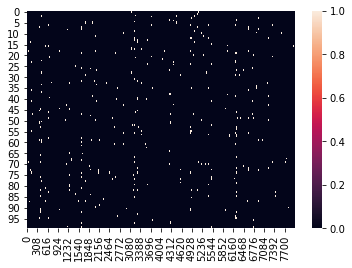

In [45]:
states = results_RNN['1_1_1']['test_states'][0].reshape((-1, hidden_dim)).T

# def standardizeStates(states):
#     states_standard = np.zeros_like(states)
#     for ni in range(states.shape[0]):#for each neuron
#         x = states[ni, :]
#         u = np.mean(x)
#         s = np.std(x)
#         z = (x - u) / s

#         states_standard[ni, :] = z

#     return states_standard

# states_standardized = standardizeStates(states)

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(states[:,:])
plt.show()

no_act, avas = findQuiesence(states)
durs = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        durs.append(ava[1]-ava[0])
    else:
        durs.append(1)

thresh=0
counts = []
for ava in avas:#for each avalanch period
    if len(ava)>1:
        tot_act = (states[ava[0]:ava[1],:] > thresh).sum()
        counts.append(tot_act)
    else:
        counts.append((states[ava[0]]> thresh).sum())

In [56]:
iters = 1000
tmax = 1000 #let the network run for 10000 time steps
durs = []
counts = []
for i in range(iters):
    results_RNN = runParameterSweep(dim_vals, steps_vals, noise_vals, random_seed, 
                                                model_type = 'OptimizedRNN', input_data_type = 'none',
                                                cv_folds = 1, input_length=1, hidden_dim=hidden_dim, batch_size = 1, 
                                                epochs=1, diverse_stim = False, model_seed = model_seed, 
                                                optimizer_type = 'Adam', hyperparams = default_params, 
                                                cv_style = cv_style, tmax = tmax, device=device, 
                                                nonlin_hid=nonlin_hid, nonlin_out = nonlin_out,
                                                net_noise_std=0.25, gain = 1.0, track_state=True, w_init='Col_Norm', w_noise_gain=0.7, threshold=0.999, c=15, dir_a=10)
    states = results_RNN['1_1_1']['test_states'][0].reshape((-1, hidden_dim)).T
    # ax = sns.heatmap(states[:,:1000])
    # plt.show()
    no_act, avas = findQuiesence(states)

    for ava in avas:#for each avalanch period
        if len(ava)>1:
            durs.append(ava[1]-ava[0])
        else:
            durs.append(1)

    thresh=0

    for ava in avas:#for each avalanch period
        if len(ava)>1:
            tot_act = (states[ava[0]:ava[1],:] > thresh).sum()
            counts.append(tot_act)
        else:
            counts.append((states[ava[0]]> thresh).sum())

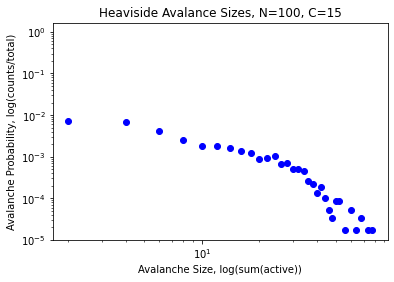

In [59]:
binwidth = 2
# bins=range(min(durs), max(durs) + binwidth, binwidth)
# hist, bin_edges = np.histogram(durs,bins=bins)

bins=range(min(counts), max(counts) + binwidth, binwidth)
hist, bin_edges = np.histogram(counts,bins=bins)

fig, ax = plt.subplots()
ax.loglog(bin_edges[:-1], hist/sum(hist), 'bo')
# ax.set_xlabel("Avalanche Durations, log(time steps)")
ax.set_xlabel("Avalanche Size, log(sum(active))")
ax.set_ylabel("Avalanche Probability, log(counts/total)")
# ax.set_title('Heaviside Avalance Durations, N=' + str(hidden_dim) + ', C=' + str(15))
ax.set_title('Heaviside Avalance Sizes, N=' + str(hidden_dim) + ', C=' + str(15))

# ax.scatter(bin_edges[:-1], hist, c='blue', edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

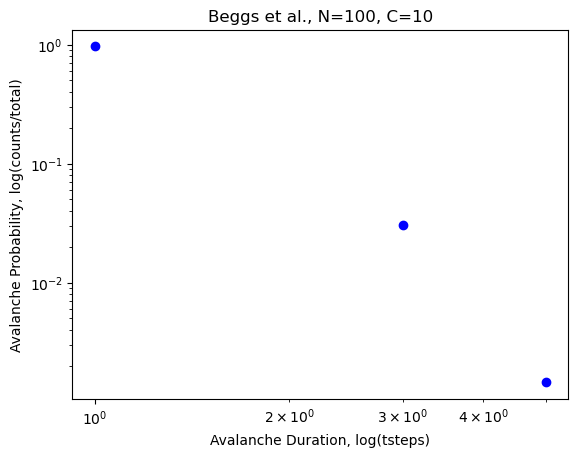

In [76]:
no_act = findQuiesence(states)
durs = []
for ava in no_act:#for each avalanch period
    if len(ava)>1:
        durs.append(ava[1]-ava[0])
    else:
        durs.append(1)

thresh=0
counts = []
for ava in no_act:#for each avalanch period
    if len(ava)>1:
        tot_act = (states[ava[0]:ava[1],:] > thresh).sum()
        counts.append(tot_act)
    else:
        counts.append((states[ava[0]]> thresh).sum())

binwidth = 2
bins=range(min(counts), max(counts) + binwidth, binwidth)
hist, bin_edges = np.histogram(counts,bins=bins)

fig, ax = plt.subplots()
ax.loglog(bin_edges[:-1], hist/sum(hist), 'bo')
ax.set_xlabel("Avalanche Size, log(counts)")
ax.set_ylabel("Avalanche Probability, log(counts/total)")
ax.set_title('Beggs et al., N=' + str(hidden_dim) + ', C=' + str(10))
# ax.scatter(bin_edges[:-1], hist, c='blue', edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()


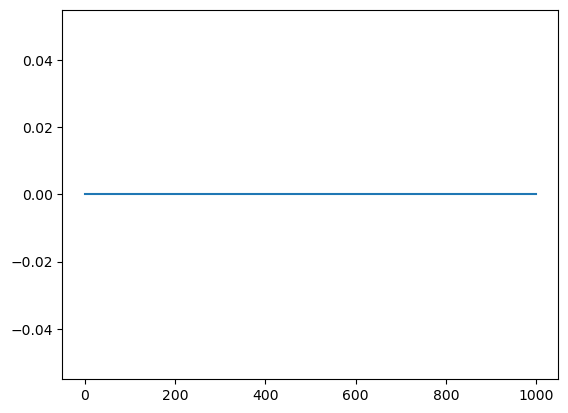

In [117]:
start = 0
stop = 1000
trange = np.arange(start, stop, 1)
plt.plot(trange, states[3, start:stop])
plt.show()

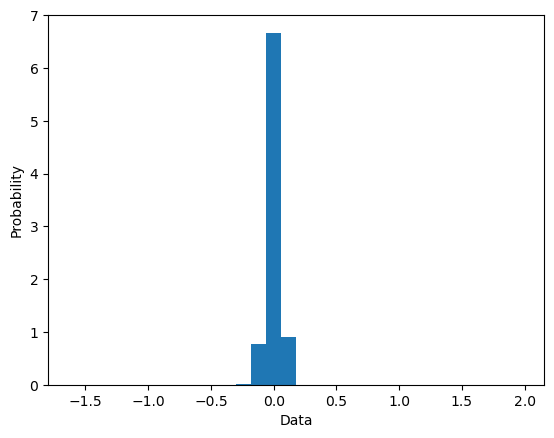

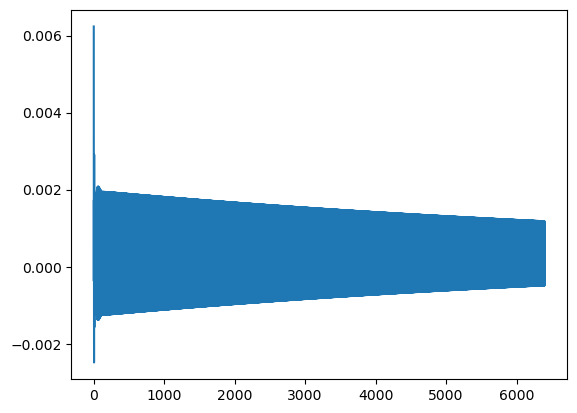

In [321]:
#you want to quantify that decrease, you compare the change in light output over the course of a certain time (delta F) 
#with the initial brightness (F).
plt.hist(states[:,0:].flatten(), density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');
plt.show()

hist=np.histogram(states[:,0:].flatten(), bins=30)

av_act = np.mean(states[:,0:], axis=0)
plt.plot(av_act)
# std = np.std(av_act)
# thresh = (np.zeros_like(av_act) + 1)*std*8.0 + np.mean(states[:,1000:])
# plt.plot(thresh, color='r', linestyle='--')
plt.show()


In [ ]:
import statsmodels
#autocovariance
def autocov(states, timeshifts):
    for i in range(timeshifts):#for the number of time shifts
        for n in range(states.shape[0]):#for each neuron in the series
        acov = statsmodels.tsa.stattools.acovf(x, adjusted=False, demean=True, fft=True, missing='none', nlag=i)

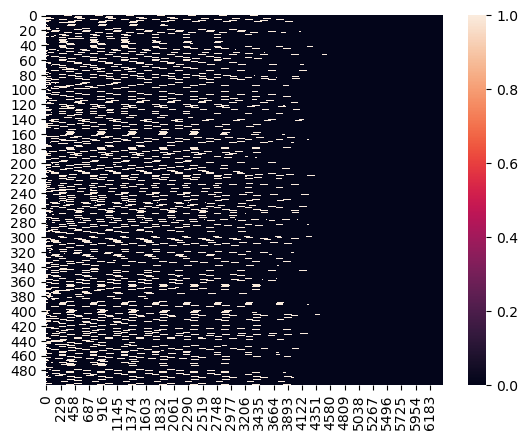

In [326]:
#do something simple like take the average network activity
#and determine an event to be activty outside 2 standard deviations from the mean.
def simpleRasterfy(states, gain=1.0, start=0):
    events = np.zeros_like(states)
    for n_itr in range(states.shape[0]):#for each neuron
        n_act = states[n_itr,:]
        av_act = np.mean(n_act[start:], axis=0)
        std = np.std(n_act)
        thresh = gain*std + av_act
        e_inds = np.where(n_act >= thresh)
        n_events = np.zeros_like(events[n_itr,:])
        n_events[e_inds] = 1.0#n_act[e_inds]
        events[n_itr, :] = n_events
    return events

#The first parameter determines the number of points of the returned wavelet array, 
# the second parameter is the scale (width) of the wavelet.
def myMorelet(points, a, **kwargs):
    M = points
    s = a
    wavelet = signal.morlet2(M, s)
    return wavelet

def waveletRasterfy(states):
    events = np.zeros_like(states)
    for n_itr in range(states.shape[0]):#for each neuron
        n_act = states[n_itr,:]
        e_inds = signal.find_peaks_cwt(n_act, widths=np.arange(1,3), wavelet=myMorelet, 
                                        max_distances=None, gap_thresh=None, min_length=None, min_snr=1, 
                                        noise_perc=20)
        n_events = np.zeros_like(events[n_itr,:])
        n_events[e_inds] = 1.0#n_act[e_inds]
        events[n_itr, :] = n_events
    return events

raster = simpleRasterfy(states, gain=1.2, start=0)
# raster = waveletRasterfy(states)
ax = sns.heatmap(raster)
plt.show()


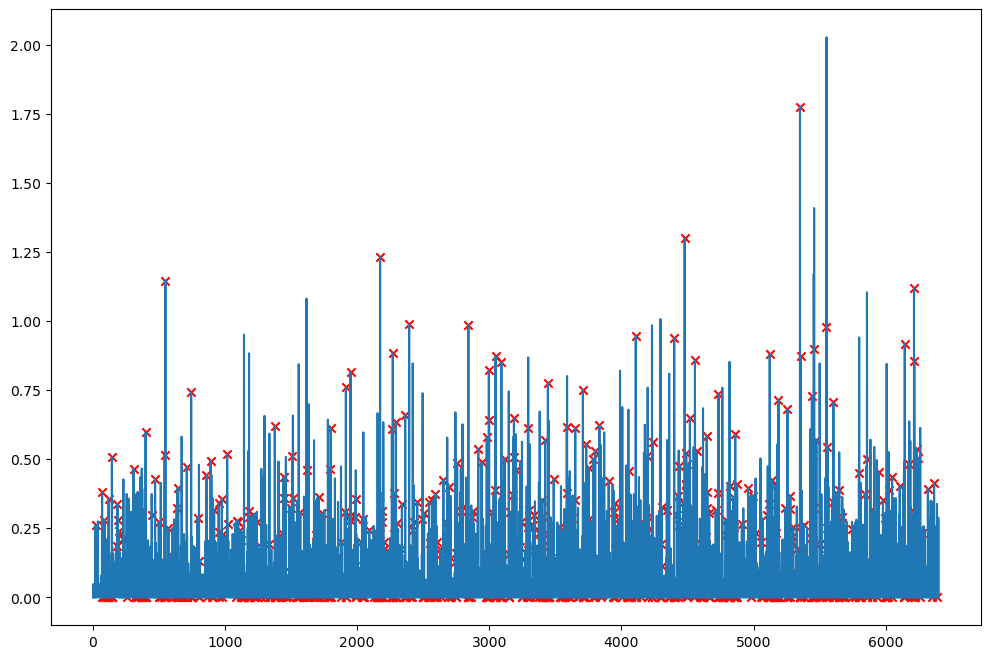

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
n_raster = raster[7, :8000]
n_data = states[7, :]
ax.plot(n_data[:8000])
peaks = np.where(n_raster == 1.0)
ax.scatter(peaks, n_data[peaks], color='r', marker='x')
plt.show()

In [64]:
#Segment the activity into avalanche duration.
def findQuiesence(raster):
    first = True
    no_act = []
    for i in range(raster.shape[1]):#along column space (i.e. per time step)
        tstep = raster[:,i]
        if sum(tstep) == 0 and first:
            curr_quiet = [i]
            first = False
        elif sum(tstep) != 0 and not first:
            if (i - 1) != curr_quiet[0]:#if the quiet period is only one time step
                curr_quiet.append(i-1)
            no_act.append(curr_quiet)
            first = True
    return no_act

no_act = findQuiesence(raster)
print(no_act)


[[0]]


In [122]:
flat_states = states.flatten()
freqs = np.zeros_like(flat_states)

if any(n < 0 for n in flat_states):#check if there are any negative values in the histogram
    #if there are, translate the sequency to being strictly positive by adding the max magnitude, negative value to all values in the sequence
    max_negative = max([n for n in flat_states if n<0])
    flat_states_pos = flat_states - max_negative#add the max negative to all entries
else:
    flat_states_pos = flat_states

hist_pos=np.histogram(flat_states_pos, bins=30)
hist_real=np.histogram(flat_states, bins=30)

for i, val in enumerate(states.flatten()):#for each state value
    for j in range(1, len(hist_pos[1])): #for each histogram bin edge
        edge = hist_pos[1][j]
        if val < edge:
            freqs[i] = hist_real[0][j-1]#grab frequency
        if val == edge:
            freqs[i] = (hist_real[0][j-2] + hist_real[0][j-1])/2#grab frequencies of both bins it is included in and take the average


KeyboardInterrupt: 

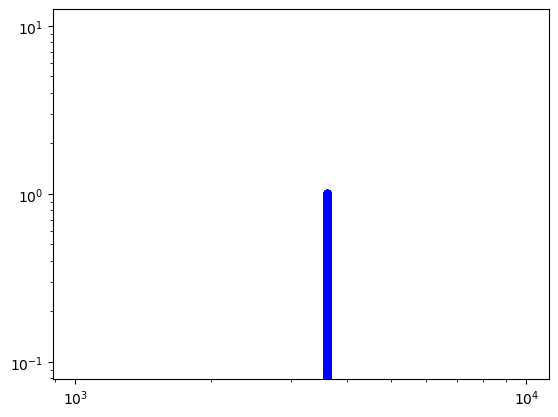

In [22]:
# Plotting the graph with Log ticks at x and y axis using loglog
# Creating figure and axes

fig = plt.figure()
ax = plt.gca()
ax.scatter(freqs, flat_states, c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(16000000,)